In [1]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Modeling - Logistic, XGBOOST, SVM
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [2]:
import sys
sys.path.append(f'../../../python')

from balance_split_data import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, create_feature_label

from grid_search import gridsearch, fit_best_model_train, evaluate, fit_best_model_test, get_feature_importance_cv

from ml_model import train_model_cross_val, train_model_test, get_feature_importance, get_feature_importance10, eval_matrix

### Load data

In [3]:
df = pd.read_json(r"../../../../data/processed/pre-processed_merged_2023_04_04.json")

In [4]:
df.columns

Index(['year', 'article_new', 'case_num', 'file', 'section_fin', 'len_pdf',
       'sec_text', 'count', 'text_clean', 'count_text', 'phase2', 'wc',
       'competition', 'case_code', 'title', 'regulation_id',
       'notification_date', 'simpl_proc', 'last_decision_date',
       'deadline_date', 'nace_code', 'article'],
      dtype='object')

### Balance data and split to train and test set

In [5]:
label_name = "wc"
random_seed=42
random_state=42

In [6]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1, random_seed=random_seed)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded, random_state=random_state)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded, text='text_clean')

Total decisions: 1574
0    1313
1     261
Name: label, dtype: int64
Balancing...
Total decisions: 522
Labels distribution: 
 0    261
1    261
Name: 0, dtype: int64
Training set shape: (417,) (417,)
Test set shape: (105,) (105,)
Creating df_train 1: 209 0: 208
Creating df_test1 1: 52 0: 53
Creating df_test concatenated with df_excluded with len: 1052
Creating df_test 1: 52 0: 1105
Grouping df_train by case_num 1: 209 0: 208
Grouping df_test by case_num 1: 52 0: 1105
Grouping df_test1 by case_num 1: 52 0: 53
Grouping df_excluded by case_num with len: 1052


In [7]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped, text='text_clean')

### Model training (with 10-fold CV) using best parameters from GridSearch

In [27]:
# for param_name in sorted(parameters.keys()):
#         print("\t%s: %r" % (param_name, best_parameters[param_name]))

# clf__C: 1
# tfidf__binary: True
# tfidf__max_df: 0.025
# tfidf__ngram_range: (2, 2)
# tfidf__norm: 'l1'
# tfidf__use_idf: False
# tfidf__lowercase': True
# tfidf__stop_words': 'english'

	clf__C: 1
	tfidf__binary: True
	tfidf__max_df: 0.025
	tfidf__ngram_range: (2, 2)
	tfidf__norm: 'l1'
	tfidf__use_idf: False


In [15]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, lowercase=False, stop_words=None, \
                                  ngram_range = (2,2), binary = True, max_df = 0.025, norm = 'l1', use_idf = False))
c = 1
# solver = 'liblinear'
model=LinearSVC(C=c)

In [16]:
df_metrics = pd.DataFrame(columns = ['set', 'tn', 'fp', 'fn', 'tp', 'recall', 'precision', 'f_score', 'fpr', 'accuracy', 'roc_auc'])

In [17]:
# balanced train
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)
set = "balanced train"
metrics_train=evaluate(y_train, y_predict_train)
row_train = pd.DataFrame({'set':set, 'tn':metrics_train[0], 'fp':metrics_train[1], 'fn':metrics_train[2], 'tp':metrics_train[3], \
                    'recall':metrics_train[4], 'precision':metrics_train[5], 'f_score':metrics_train[6], \
                    'fpr':metrics_train[7], 'accuracy':metrics_train[8], 'roc_auc':metrics_train[9]}, index=[0])


# balanced test
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)
set = "balanced test"
metrics_test1=evaluate(y_test1, y_predict_test1)
row_test1 = pd.DataFrame({'set':set, 'tn':metrics_test1[0], 'fp':metrics_test1[1], 'fn':metrics_test1[2], 'tp':metrics_test1[3], \
                        'recall':metrics_test1[4], 'precision':metrics_test1[5], 'f_score':metrics_test1[6], \
                        'fpr':metrics_test1[7], 'accuracy':metrics_test1[8], 'roc_auc':metrics_test1[9]}, index=[0])


# imbalanced test
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)
set = "imbalanced test"
metrics_test=evaluate(y_test, y_predict_test)
row_test = pd.DataFrame({'set':set, 'tn':metrics_test[0], 'fp':metrics_test[1], 'fn':metrics_test[2], 'tp':metrics_test[3], \
                    'recall':metrics_test[4], 'precision':metrics_test[5], 'f_score':metrics_test[6], \
                    'fpr':metrics_test[7], 'accuracy':metrics_test[8], 'roc_auc':metrics_test[9]}, index=[0])

df_metrics = pd.concat([df_metrics.loc[:], row_train, row_test1, row_test]).reset_index(drop=True)
df_metrics['n'] = df_metrics['tn'] + df_metrics['fp'] + df_metrics['fn'] + df_metrics['tp']

***10-fold cross-validation***
Accuracy: 0.5143540669856459

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.12      0.20       208
           1       0.51      0.90      0.65       210

    accuracy                           0.51       418
   macro avg       0.53      0.51      0.42       418
weighted avg       0.53      0.51      0.43       418


CR: (0.5324694667858207, 0.5124771062271062, 0.4247147438287717, None)

Confusion matrix:
 [[ 25 183]
 [ 20 190]] 

_______________________


 Accuracy: 51.435 
 Precision: 0.509 
 Recall: 0.905 
 F1: 0.652 
 FPR: 0.880 
 ROC_AUC: 0.512
Accuracy: 0.5143540669856459

Classification report:
               precision    recall  f1-score   support

           0       0.56      0.12      0.20       208
           1       0.51      0.90      0.65       210

    accuracy                           0.51       418
   macro avg       0.53      0.51      0.42       418
weighted avg       0.53 

In [18]:
df_metrics

,set,tn,fp,fn,tp,recall,precision,f_score,fpr,accuracy,roc_auc,n
0,balanced train,25,183,20,190,0.904762,0.509383,0.651801,0.879808,51.435407,0.512477,418
1,balanced test,19,34,7,46,0.867925,0.575000,0.691729,0.641509,61.320755,0.613208,106
2,imbalanced test,205,900,7,46,0.867925,0.048626,0.092092,0.814480,21.675302,0.526722,1158


In [12]:
df_metrics.to_excel('../../../../output/tables/svm_metrics_wc.xlsx', index=True)

### Confusion matrix and model performance

In [13]:
merger_info = pd.read_json(r"../../../../data/processed/merger_info_2023_03_25.json")

In [14]:
results_train, tn, fp, fn, tp = eval_matrix(df_train_grouped, merger_info, X_train, y_train, y_predict_train)

In [15]:
results1, tn, fp, fn, tp = eval_matrix(df_test1_grouped, merger_info, X_test1, y_test1, y_predict_test1)

In [16]:
results2, tn, fp, fn, tp = eval_matrix(df_test_grouped, merger_info, X_test, y_test, y_predict_test)

In [17]:
print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 656
FP: 448
FN: 4
TP: 50


In [18]:
tn['nace_code'].value_counts().head(6)

Telecommunications                                                    22
Manufacture of other parts and accessories for motor vehicles         15
Financial service activities, except insurance and pension funding    15
Manufacture of chemicals and chemical products                        14
Wholesale of computers, computer peripheral equipment and software     9
Computer programming, consultancy and related activities               8
Name: nace_code, dtype: int64

In [19]:
fp['nace_code'].value_counts().head(6)

Telecommunications                                                                                                    17
Manufacture of chemicals and chemical products                                                                        15
Manufacture of basic pharmaceutical products and pharmaceutical preparations                                          15
Manufacture of basic chemicals, fertilisers and nitrogen compounds, plastics and synthetic rubber in primary forms     9
Manufacture of pharmaceutical preparations                                                                             8
Manufacture of other parts and accessories for motor vehicles                                                          6
Name: nace_code, dtype: int64

In [20]:
fp['nace_code'].str.contains("pharma").sum()

43

In [21]:
fn['nace_code'].value_counts().head(6)

Manufacture of chemicals and chemical products                                                                                                                                                                                                                                                                                1
Electric power generation, transmission and distribution                                                                                                                                                                                                                                                                      1
Cargo handling; Land transport and transport via pipelines; Sea and coastal freight water transport; Service activities incidental to water transportation; Support activities for transportation                                                                                                                             1
Electric power generation, transmission 

In [22]:
tp['nace_code'].value_counts().head(6)

Manufacture of basic pharmaceutical products and pharmaceutical preparations                   6
Manufacture of chemicals and chemical products                                                 3
Computer programming, consultancy and related activities                                       2
Wireless telecommunications activities                                                         2
Aquaculture                                                                                    2
Information service activities; Programming and broadcasting activities; Telecommunications    2
Name: nace_code, dtype: int64

### Feature importance

In [19]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
4282,monomer including,-0.728844,0.728844
533,million Aviva,-0.728843,0.728843
921,million Suntory,-0.728842,0.728842
611,million Cunningham,-0.728841,0.728841
860,million Repsol,-0.728840,0.728840
913,million Sonepar,-0.728839,0.728839
4676,monthly auction,-0.728839,0.728839
494,million ARDIAN,-0.728838,0.728838
2693,mobile initiated,-0.728838,0.728838
3517,modular analysis,-0.728838,0.728838


Get features for label = 1 and label = 0

In [20]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

(array([-0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 [Text(-0.6000000000000001, 0, '−0.6'),
  Text(-0.4000000000000001, 0, '−0.4'),
  Text(-0.20000000000000007, 0, '−0.2'),
  Text(0.0, 0, '0.0'),
  Text(0.19999999999999996, 0, '0.2'),
  Text(0.3999999999999999, 0, '0.4'),
  Text(0.6000000000000001, 0, '0.6'),
  Text(0.8, 0, '0.8')])

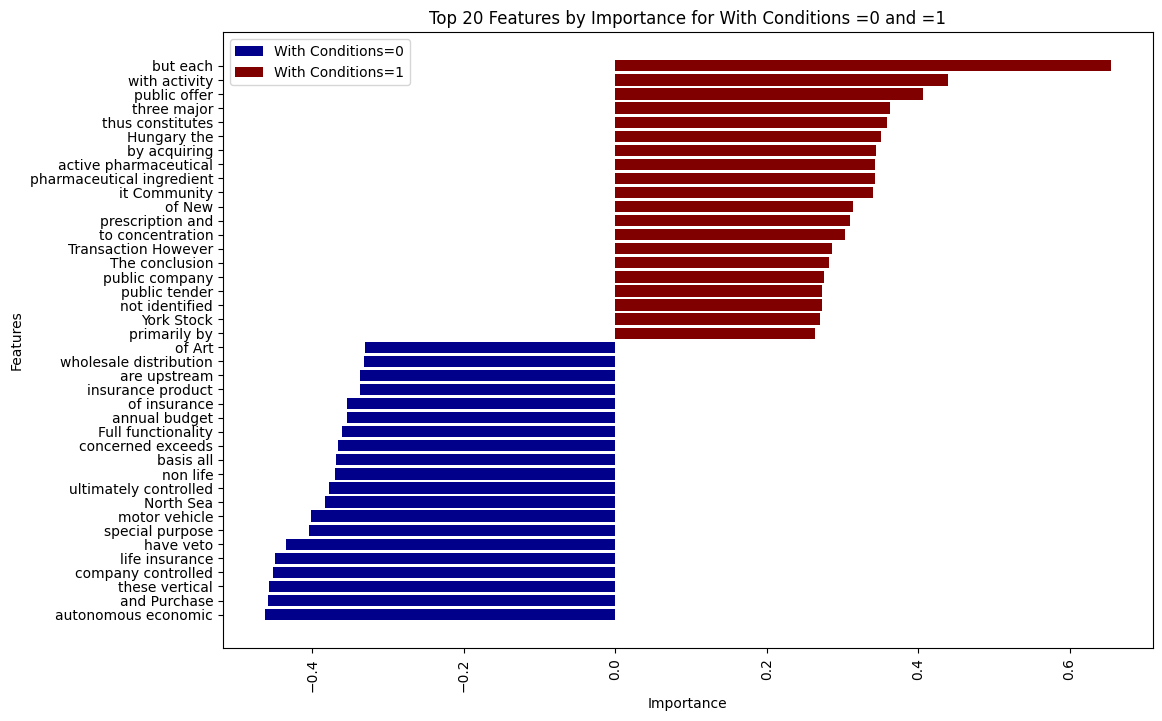

In [14]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='With Conditions=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='With Conditions=1')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
ax.set_title('Top 20 Features by Importance for With Conditions =0 and =1')
ax.legend()
plt.xticks(rotation=90)
# plt.show()

# plt.savefig('../../../../output/figures/svm_full_wc.png', bbox_inches='tight')

In [26]:
df_features_train.to_excel('../../../../output/tables/features_svm_train_full_wc.xlsx', index=True)